Name: Aurellia Vieryn <br>
NIM : 24400666626

## UAS: DEEP LEARNING - CASE 1: SEGMENTATION
For this case of image segmentation, we want to use U-Net architecture. U-Net is a kind of CNN (Convolutional Neural Network) which is usually used for Biomedical Image Segmentation. <br>

**Why U-Net?** <br>
U-Net is said to be fast and precise for image semantic segmentation, and one of the good models to do this problem. Since this architecture is usually used for segmenting biomedical images, of course it can be used to detect forests from aerial images. It is also said that this architecture works well with fewer training datas. It consists of 23 convolutional layers spread over encoder network, encoder, and also decoder. <br><br>

Another reason is because Attention Model can be applied to this architecture, and people have tried to do it. The idea was originated from this [paper](https://arxiv.org/pdf/1804.03999.pdf) by Oktay, Schlemper, and others. The applied attention is named Attention Gate in the architecture. <br><br>

In conclusion, in this case, we want to compare the accuracy of the U-Net Model and Attention U-Net Model for image semantic segmentation. Not only that, we also want to see the difference in results between both models.

### Importing Aerial Dataset

The dataset that was given was the Forest Segmented dataset, which is a dataset of images taken from the sky (plane probably) of lands. The images was then divided to a lot of pieces. The purpose of this image semantic segmentation is to detect forests in the lands. The question in the test paper told us to segment skin cancer or forest fire but I think this dataset predicts the forest area.<br><br>

This dataset will also contains the masks files in the zip. Masks are the pre-defined forest area, so it is used for detecting the forest area (something target variable). <br> <br>

First, we upload the dataset given to our own Google Drive storage, and then access the data from Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


Since the dataset is in .zip file, we unzip the dataset. This unzipped folders will go to the path above.

In [3]:
!unzip 'Aerial Image Dataset'.zip

Streaming output truncated to the last 5000 lines.
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_m

### Importing Library

Here, we import all the libraries which will be needed for the process.

In [3]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
import os
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split
from warnings import filterwarnings

In [4]:
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.layers import concatenate
from keras.layers import Multiply
from keras.layers import Input

Setting the random seed to 42 because later we will use a lot of randomization.

In [5]:
np.random.seed(42)

### Getting the Data (Images and Masks)

We define the paths for images and masks, which is just copied from the files section in Colab. `/*.jpg` means that it takes every file that ends with .jpg, the images.

In [6]:
image_path = "/content/gdrive/MyDrive/Forest Segmented/Forest Segmented/images/*.jpg"
mask_path = "/content/gdrive/MyDrive/Forest Segmented/Forest Segmented/masks/*.jpg"

Next, we want to sort the images so that the image matches the corresponding mask.

In [7]:
image_names = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_names = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

### Data Preprocessing

We want to tidy up the images for easier processing. First, we want to define a function to resize the images so the training process later won't take up too much time.

In [8]:
def img_resize(image, y_dim, x_dim):
    resized_img = cv2.resize(image, (y_dim,x_dim))
    return resized_img

The second thing we want to do is to put the sorted images and masks in arrays. We also want to take only the first 1000 images and masks, so it's like taking 1000 samples for faster training because the RAM is always full if we use all 5108 datas. We also resize the images and masks here with the function we defined before. For the masks, we read the images using grayscale color  and for the images, using normal RGB.

In [9]:
image_array = []
count = 0

for image in image_names:
    img = cv2.imread(image, -1)
    img = img_resize(img, 128, 128)
    image_array.append(img)
    count+=1
    if count == 1000: break
    
image_array = np.array(image_array)

In [11]:
mask_array = []
count = 0

for mask in mask_names:
    msk = cv2.imread(mask, 0)
    msk = img_resize(msk, 128, 128)
    mask_array.append(msk)
    count+=1
    if count == 1000: break
    
mask_array = np.array(mask_array)

We check the random array of an image, and also its shape. Same goes for the masks. Then, check the length too. Since we only want to use 1000 datas, the length should be 1000 for both images and masks.

In [12]:
import random
random.seed(42)
num = random.randint(0,100)
print(f"Random image array element: {image_array[num]}\n")
print(f"Image shape: {image_array[num].shape}\n")

print(f"Random mask array element: {mask_array[num]}\n")
print(f"Mask shape: {mask_array[num].shape}\n")

print(f"Image array length: {len(image_array)}\n")
print(f"Mask array length: {len(mask_array)}\n")

Random image array element: [[[61 75 63]
  [41 54 45]
  [49 60 49]
  ...
  [59 78 64]
  [79 97 81]
  [68 85 70]]

 [[57 71 59]
  [54 68 58]
  [67 80 67]
  ...
  [47 61 54]
  [70 84 77]
  [55 69 62]]

 [[38 52 41]
  [54 66 54]
  [75 88 71]
  ...
  [59 73 68]
  [54 66 60]
  [49 62 54]]

 ...

 [[55 70 62]
  [70 86 79]
  [58 78 68]
  ...
  [69 94 82]
  [49 73 65]
  [61 83 80]]

 [[66 83 69]
  [48 64 56]
  [56 74 64]
  ...
  [66 90 76]
  [72 92 84]
  [72 92 83]]

 [[74 91 78]
  [58 74 62]
  [71 91 74]
  ...
  [50 68 61]
  [54 70 66]
  [60 76 70]]]

Image shape: (128, 128, 3)

Random mask array element: [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]

Mask shape: (128, 128)

Image array length: 1000

Mask array length: 1000



The shape of the image is in channel 3 and mask has nothing (grayscale). Also, the length for both is already the same as what we expected. We also want to normalize these arrays for better execution and better accuracy. Put the images to X variable and masks to y variable.

In [13]:
def normalize_array(arr):
    return arr/255.0

X = normalize_array(image_array)
y = normalize_array(mask_array)

Let's now check one of the examples of the image and mask.

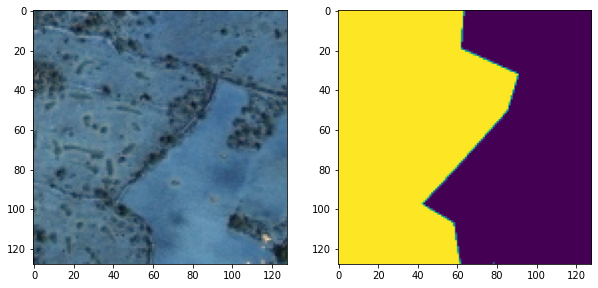

In [14]:
random_number = random.randint(0,500)

fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(X[random_number])
ax[1].imshow(y[random_number])

The figures above shows us the original image (left) and the mask (right). The mask should be grayscale but it actually doesn't matter that much. The mask is the kind of like the actual forest area, and here, the yellow part is the forest area and the purple part is the non-forest area. So, in short, the yellow part is the segmented forest. <br><br>

Next, we want to split out X and y variables to training and testing datas. with the testing size 10% and the training size 90% (with random state 23 not 42).

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=23)

Check the shape. The length for X should be 900 and y should be 100 because the original length is 1000.

In [16]:
X_train.shape

(900, 128, 128, 3)

In [17]:
X_test.shape

(100, 128, 128, 3)

### U-Net Model Architecture

The architecture we decided to use in the first part was the U-Net. U-Net consists of a Encoder Network, Encoder and Decoder. The full architecture visualization: <br><br>
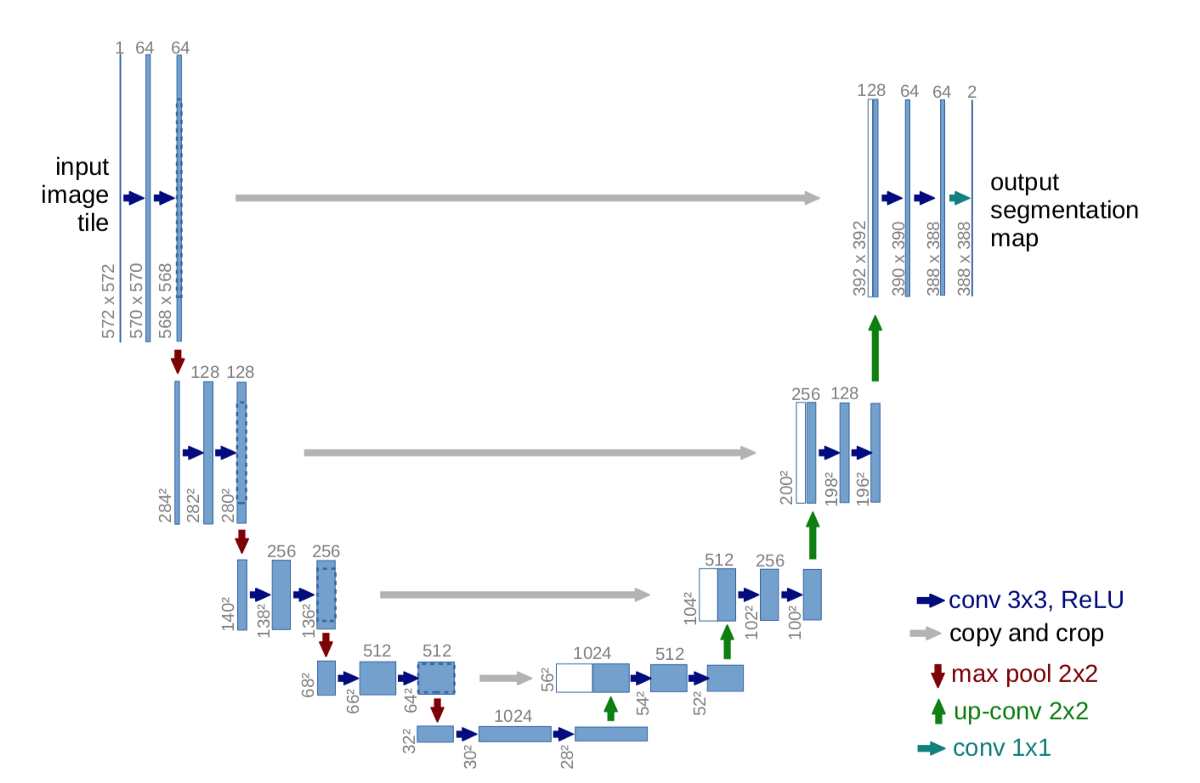


From the image, we can make the encoder block. It is shown that an encoder block consists of two convolutional 3x3 layers, and then pooling the layer with MaxPool. This process is done 4 times in the architecture visualization. We will also insert dropout between the layers because it usually makes the results better. If pooling is done, we will return two outputs, because one of them is needed for the copy and crop process in the decoder phase.

In [18]:
from keras.layers import Layer
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'filters':self.filters,
            'rate':self.rate,
            'pooling':self.pooling
            }

For the decoder block, we will use upsampling 2x2 layer and then use another two convolutional 3x3 layers. This is also repeated for 4 times. Also, after upsampling, we will concatenate from the encoder block because it is told to copy and crop.

In [19]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        x = concatenate([x, skip_X])
        x = self.net(x)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'filters':self.filters,
            'rate':self.rate
            }

Now, we can make the full architecture. 

* Our input image is the original image, which has the shape of 128x128x3. 
* Then we use the Encoder Block 4 times for the Encoder Network with the filter increasing twice each block. The starting filter is 32. 
* Next, the encoding part, which is the middle part, is the encoder block without pooling. 
* The decoder part uses 4 Decoder Block and each filter is half the size.
* Lastly, the output layer gives out the finishing filter 1. 

The dropout rate used throughout the architecture must be appropriate to the "mirrored" part.


In [20]:
input_layer = Input(shape=(128, 128, 3), name="InputLayer")

# Encoder Network
p1, c1 = EncoderBlock(32, 0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256, 0.2, name="Encoder4")(p3)

# Encoding
c5 = EncoderBlock(512, 0.3, pooling=False, name="EncodingLayer")(p4)

# Decoder
d1 = DecoderBlock(256,0.2, name="Decoder1")([c5, c4])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, c3])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, c2])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, c1])

# Output
output_layer = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(d4)

### Modelling U-Net

Since our architecture is ready to use, we can instantly make a model for image segmentation. We use Adam Optimizer, Binary Crossentropy for loss calculations, and also Accuracy for the model metrics.

In [21]:
# Model
model = Model(inputs=[input_layer], outputs=[output_layer])

# compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

We will check the summary of our model.

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder1 (EncoderBlock)        ((None, 64, 64, 32)  10144       ['InputLayer[0][0]']             
                                , (None, 128, 128,                                                
                                32))                                                              
                                                                                                  
 Encoder2 (EncoderBlock)        ((None, 32, 32, 64)  55424       ['Encoder1[0][0]']           

The summary shows similiarity to the architecture visualization, but in a less detailed version. But, the point of the architecture is there. Let's now train our model for testing. Before that let's checkpoint and put early stopping.

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint("/kaggle/working/forest_image_segmentor_model.h5",save_best_only=True)

### Training U-Net

The go through the training data 10 times (epoch = 10). I also think that the training process doesn't need early stopping because we only use 10 epochs. 10 epochs so that our RAM won't run out easily.

In [24]:
num_epochs = 10

history = model.fit(X_train,y_train,epochs=num_epochs,callbacks=[early_stopping_cb], validation_data=(X_test, y_test))

Epoch 1/10
29/29 [==============================] - 22s 254ms/step - loss: 0.7670 - accuracy: 0.5805 - val_loss: 0.7084 - val_accuracy: 0.4477
Epoch 2/10
29/29 [==============================] - 5s 179ms/step - loss: 0.6264 - accuracy: 0.6256 - val_loss: 0.6155 - val_accuracy: 0.6754
Epoch 3/10
29/29 [==============================] - 5s 180ms/step - loss: 0.5837 - accuracy: 0.6936 - val_loss: 0.5958 - val_accuracy: 0.6887
Epoch 4/10
29/29 [==============================] - 5s 180ms/step - loss: 0.5441 - accuracy: 0.7341 - val_loss: 0.5832 - val_accuracy: 0.7010
Epoch 5/10
29/29 [==============================] - 5s 187ms/step - loss: 0.5382 - accuracy: 0.7357 - val_loss: 0.5807 - val_accuracy: 0.6916
Epoch 6/10
29/29 [==============================] - 5s 180ms/step - loss: 0.5302 - accuracy: 0.7443 - val_loss: 0.6040 - val_accuracy: 0.6719
Epoch 7/10
29/29 [==============================] - 5s 183ms/step - loss: 0.5344 - accuracy: 0.7327 - val_loss: 0.5502 - val_accuracy: 0.7210
Epoch

With a total of 10 epochs, we managed to get an accuracy of 76.65% and loss 0.4821 (less than 1). Also, 69.31% accuracy and 0.6069 loss in validation. This means that the model using U-Net architecture is decent enough to segment forest area. These values may improve if we use bigger training data (not sampling). <br> <br>

### U-Net Model on Test Data
We will also see the result of the image segmentation using U-Net on the test data.

1/1 [==============================] - 0s 16ms/step


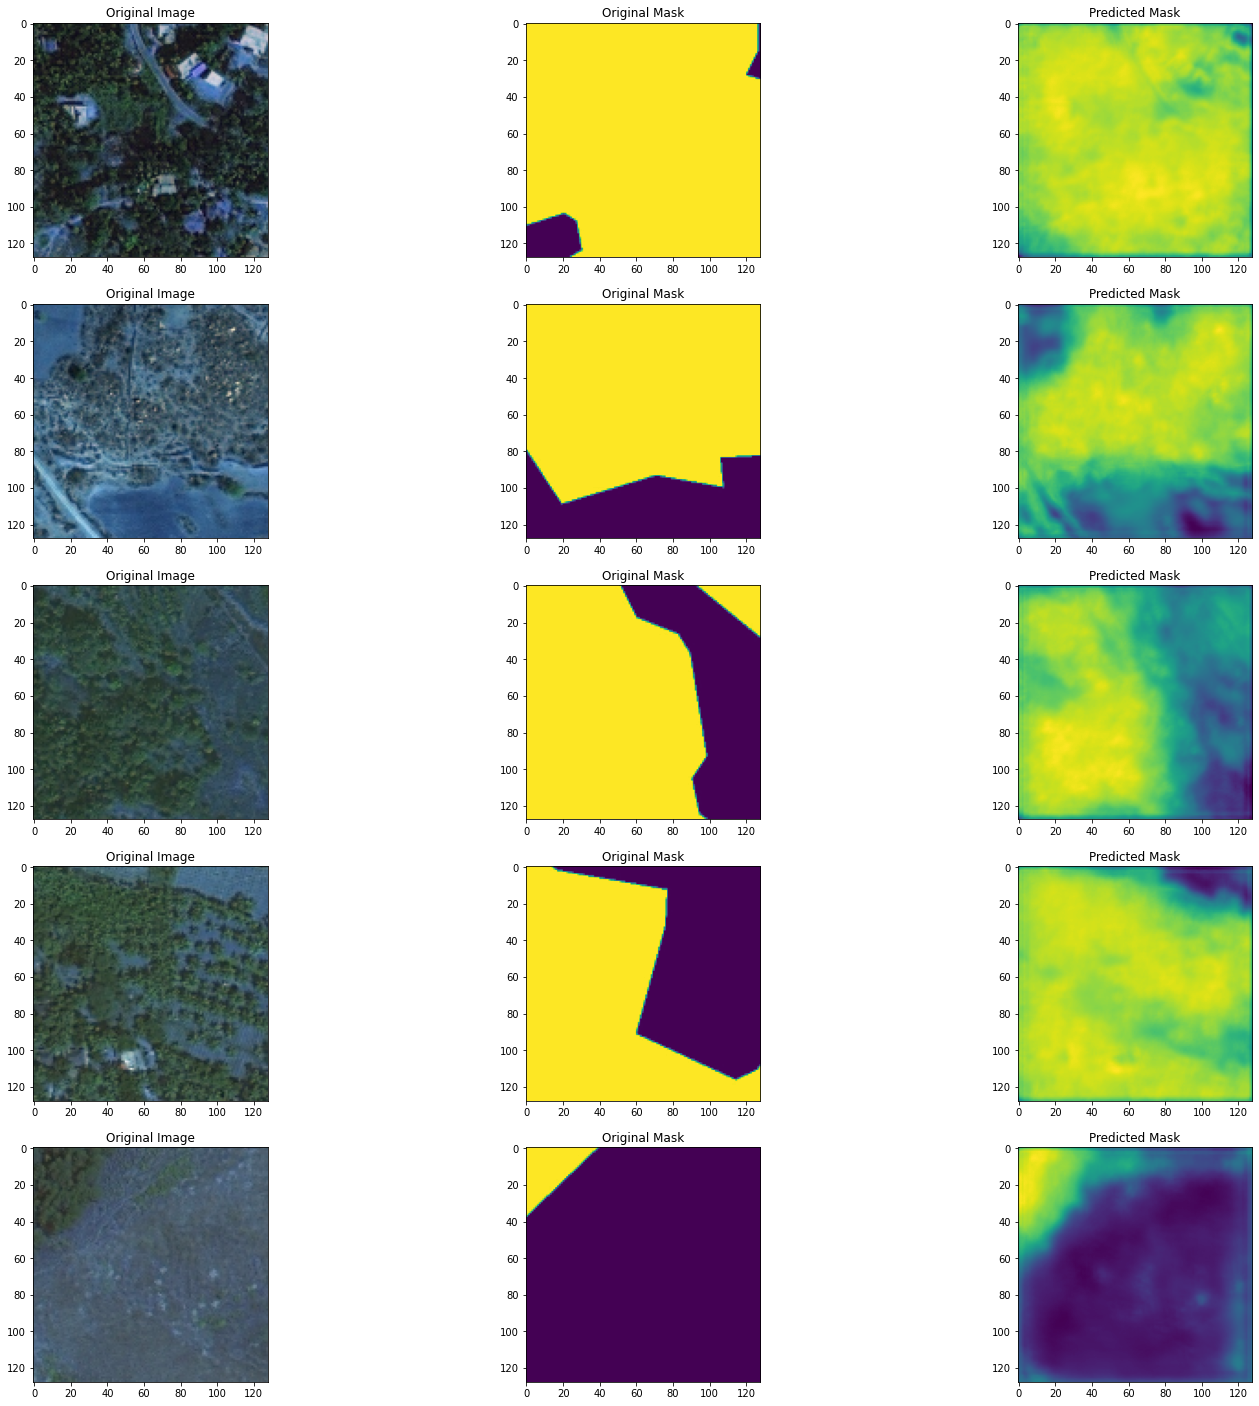

In [25]:
figure, axes = plt.subplots(5,3, figsize=(25,25))

for i in range(0,5):
    rand_num = random.randint(0,100)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')
    
    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')
    
    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128,128)
    axes[i,2].imshow(predicted_mask)
    axes[i,2].title.set_text('Predicted Mask')

We can see that the predicted for the test datas is similar to the masks of the test data. I personally think that the predicted results are better than the original masks because it is more detailed and has more than 1 color (the lighter the color means higher chance of it being a forest area). Overall, the results are good to segment forest areas.

### Attention U-Net Architecture

The next thing we want to do is to apply attention to the U-Net architecture. Attention is a mechanism that focuses on a certain part of the input and then noticing it more. This definition is also applied in image segmentation. Attention will gives out a weighted output. Weighted means that certain parts are given more attention based on the things it learned. In short, attention works like what a human vision would see first.<br> <br>

I will use Soft Attention for the attention part, because soft attention can choose which parts to focus on based on its importance. Soft attention is also used more than hard attention because of its differentiability. For this case, soft attention being implemented at the skip connections will minimize segmentation at irrelevant regions. Usually, soft attentions has better results too. <br> <br>

For the code, soft attention uses softmax function and will be put together in a process called Attention Gate. It consits of 3 convolutional layers (2 ReLu and 1 Sigmoid), 1 upsampling layer, 1 add layer, 1 multiply layer, and also a softmax function.

In [26]:
from keras.layers.activation.softmax import Softmax
class AttentionGate(Layer):

    def __init__(self, filters, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.normal = Conv2D(filters, kernel_size=3, padding='same', kernel_initializer='he_normal', activation='relu')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal', activation='relu')
        self.add = Add()
        self.resample = UpSampling2D()
        self.learn = Conv2D(1,kernel_size=1, padding='same', activation='sigmoid') 
        self.soft = Softmax()
        self.adapt = Multiply()

    def call(self, X):
        X, skip_X = X
        x = self.normal(X)
        skip = self.down(skip_X)
        x = self.add([x, skip])
        x = self.learn(x)
        x = self.soft(x)
        x = self.resample(x)
        f = self.adapt([x,skip_X])
        return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'filters':self.filters,
            }

For this Attention U-Net architecture, the visualization from the paper linked in the first part is like this:
<br><br>
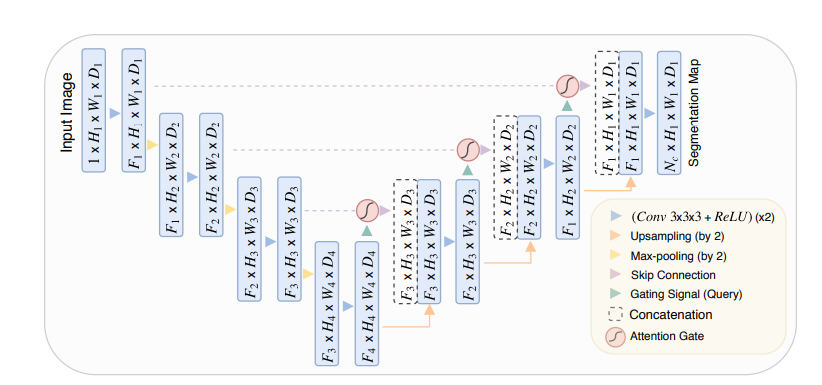


It is basically the same architecture as the U-Net but with the AttentionGate added. It is added throughout the decoding process, before each decoder block. <br><br>
From the picture, it is shown that there are only 3 AttentionGates because of the decoder blocks are only 3. But we will just adjust this model so that it is the same as the one we made before (the U-Net). This means that the total of Attention Gates would be 4. We also adjust the amount of encoder blocks (only 3 in the picture).
<br><br>
Also, we refer the decoder block based on the attention model now, not the encoder, because the attention model adds weight to the output. It can be clearly detected in the architecture.

In [27]:
input_layer = Input(shape=(128, 128, 3), name="InputLayer")

# Encoder Network
p1, c1 = EncoderBlock(32, 0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256, 0.2, name="Encoder4")(p3)

# Encoding
c5 = EncoderBlock(512, 0.3, pooling=False, name="EncodingLayer")(p4)

# Attention + Decoder
a1 = AttentionGate(256, name="Attention1")([c5, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([c5, a1])

a2 = AttentionGate(128, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output
output_layer = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(d4)

### Modelling Attention U-Net

We have made the image segmentation model using attention, so now we will model the architecture to test the testing data. The model will once again use Adam Optimizer, Binary Crossentropy for loss calculations, and Accuracy for model metrics.

In [28]:
# Model
model = Model(inputs=[input_layer], outputs=[output_layer])

# compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder1 (EncoderBlock)        ((None, 64, 64, 32)  10144       ['InputLayer[0][0]']             
                                , (None, 128, 128,                                                
                                32))                                                              
                                                                                                  
 Encoder2 (EncoderBlock)        ((None, 32, 32, 64)  55424       ['Encoder1[0][0]']         

The summary shows that the model is similar to the architecture once again. Next, we will decide an early stopping and make checkpoint again.

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint("/kaggle/working/forest_image_segmentor_model.h5",save_best_only=True)

### Training Attention U-Net

We will once again use 10 epochs here.

In [31]:
num_epochs = 10

history = model.fit(X_train,y_train,epochs=num_epochs,callbacks=[early_stopping_cb], validation_data=(X_test, y_test))

Epoch 1/10
29/29 [==============================] - 10s 255ms/step - loss: 0.7542 - accuracy: 0.5664 - val_loss: 0.6818 - val_accuracy: 0.5800
Epoch 2/10
29/29 [==============================] - 7s 226ms/step - loss: 0.6255 - accuracy: 0.6478 - val_loss: 0.6246 - val_accuracy: 0.6657
Epoch 3/10
29/29 [==============================] - 7s 225ms/step - loss: 0.6081 - accuracy: 0.6621 - val_loss: 0.6223 - val_accuracy: 0.6417
Epoch 4/10
29/29 [==============================] - 7s 226ms/step - loss: 0.5855 - accuracy: 0.6889 - val_loss: 0.6046 - val_accuracy: 0.6834
Epoch 5/10
29/29 [==============================] - 7s 226ms/step - loss: 0.5811 - accuracy: 0.6912 - val_loss: 0.5964 - val_accuracy: 0.6820
Epoch 6/10
29/29 [==============================] - 7s 227ms/step - loss: 0.5682 - accuracy: 0.7060 - val_loss: 0.5835 - val_accuracy: 0.6872
Epoch 7/10
29/29 [==============================] - 7s 230ms/step - loss: 0.5468 - accuracy: 0.7226 - val_loss: 0.5823 - val_accuracy: 0.6947
Epoch

The outputs shows an accuracy of 77.26% and a loss value of 0.4831 (less than 1). The accuracy for the validation is 68.06% and the loss value is 0.4831. This result is better than the U-Net model without attention. Better here means that the predicted results has more similiarity to the masks (target variable). This also proves that attention model boosts the process of image semantic segmentation. In short, we can say that Attention U-Net model is better at segmenting forest area than the U-Net model. <br><br>

### Attention U-Net Model on Test Data

Lastly, we want to see the predicted results on the test data.

1/1 [==============================] - 0s 15ms/step


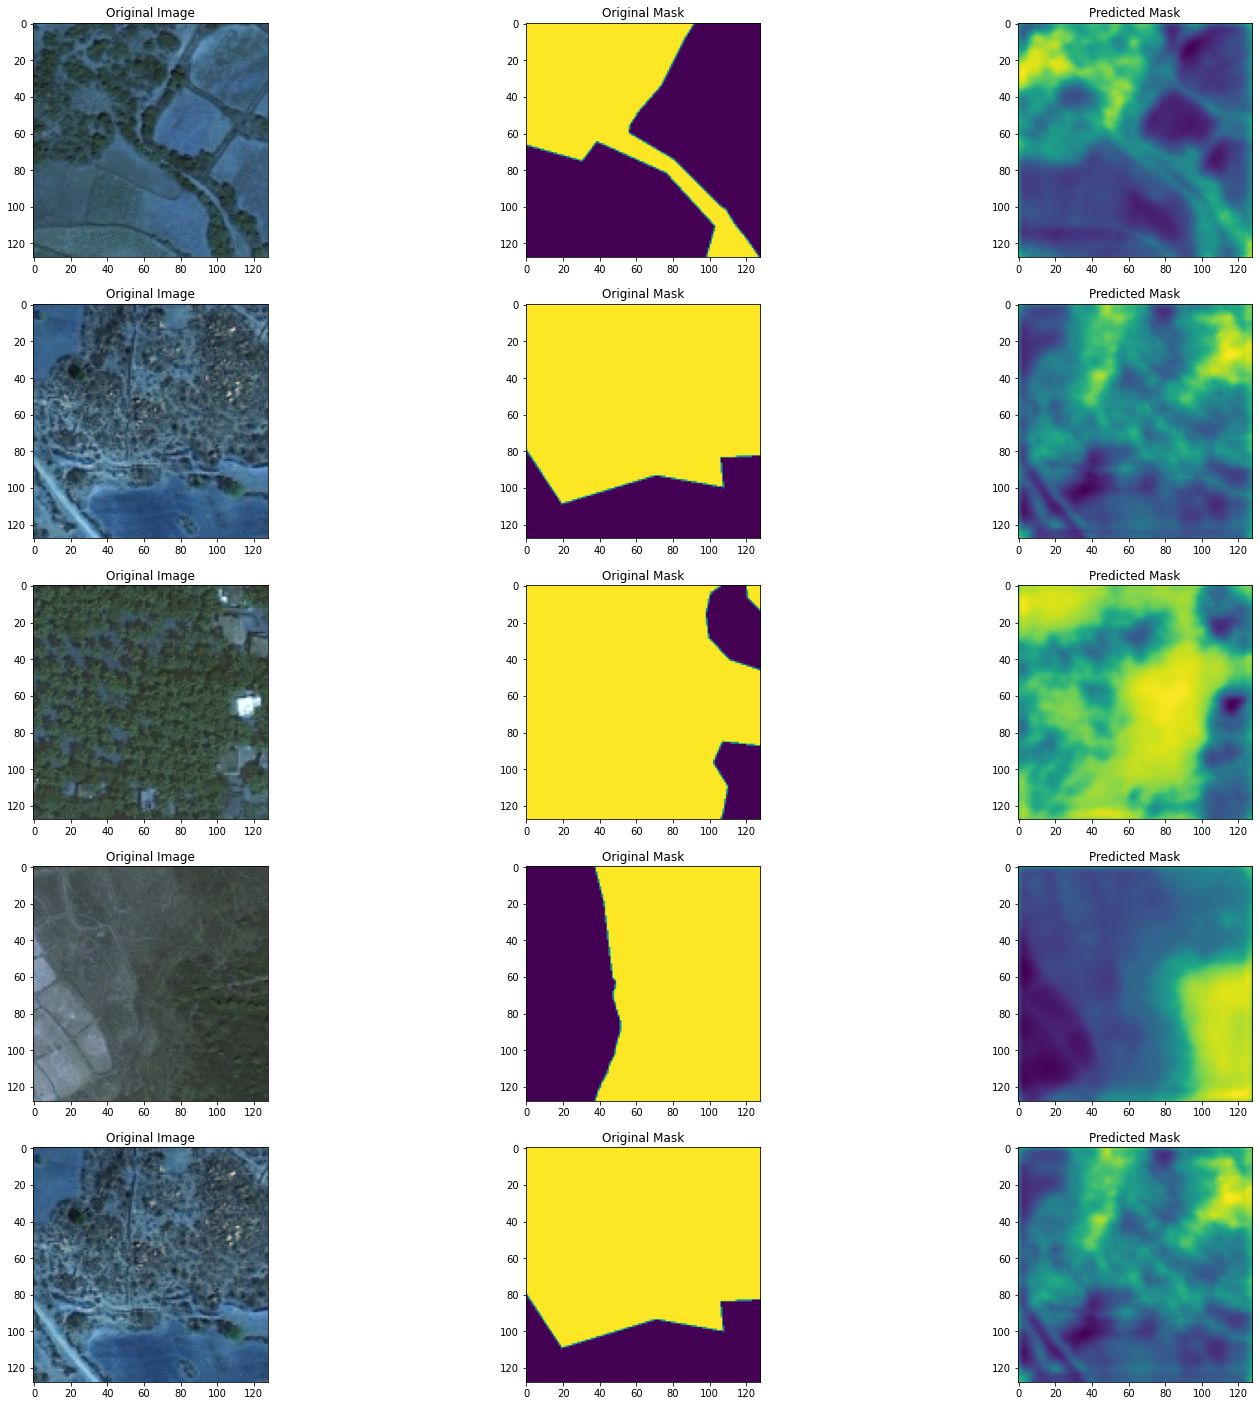

In [32]:
figure, axes = plt.subplots(5,3, figsize=(25,25))

for i in range(0,5):
    rand_num = random.randint(0,100)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')
    
    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')
    
    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128,128)
    axes[i,2].imshow(predicted_mask)
    axes[i,2].title.set_text('Predicted Mask')

We can see that the predicted for the test datas is similar to the masks of the test data once again. But, it is not that similar since the masks are more general in my opinion. The predicted results is more detailed in segmenting the forest area, and even more detailed than the U-Net model from what I see.

### Conclusion

After testing U-Net model and Attention U-Net model, we can conclude that the Attention U-Net model is better. Attention U-Net model shows higher accuracy, less amount of loss values, and more detailed predicted results. This also proves that adding attention model brings a better result in image semantic segmentation. The conclusion is that we can say that we can segment forest area from aerial images with an accuracy of 77.26% (Attention U-Net).